Fitting a power law to the results of the model ladder
===

In [1]:
pile_ce = {
    "baseline-150M-2xC": 2.731,
    "baseline2-150M-2xC": 2.726,
    "baseline-300M-2xC": 2.501,
    "baseline2-150M-5xC": 2.616,
    "baseline-300M-5xC": 2.403,
    "baseline-1B-2xC": 2.198,
    "baseline-300M-1xC": 2.601,
    "baseline-300M-3xC": 2.457,
    "baseline-300M-4xC": 2.425,
    "baseline-750M-2xC": 2.290
}

c4_ce = {
    "baseline-150M-2xC": 3.328,
    "baseline2-150M-2xC": 3.327,
    "baseline-300M-2xC": 3.104,
    "baseline2-150M-5xC": 3.221,
    "baseline-300M-5xC": 3.009,
    "baseline-1B-2xC": 2.791,
    "baseline-300M-1xC": 3.203,
    "baseline-300M-3xC": 3.058,
    "baseline-300M-4xC": 3.028,
    "baseline-750M-2xC": 2.885
}

import re
run_name_re = re.compile(r"^([^-]+)-([^-]+)-([^-]+)$")

import ladder
def parse_run_name(name: str):
    name, size, length = run_name_re.match(name).groups()
    size = ladder.parse_size(size)
    length = ladder.parse_length(length, size)
    return name, size, length
    

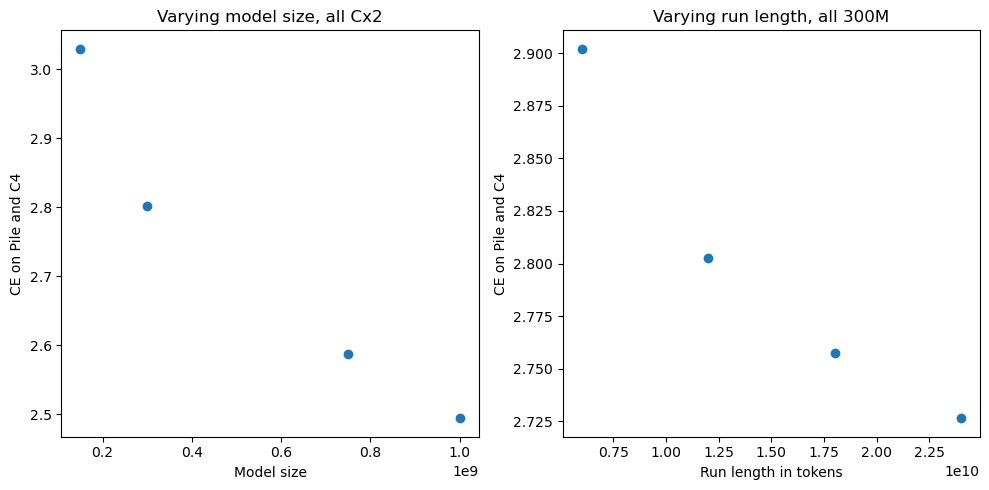

In [2]:
import matplotlib.pyplot as plt

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# make model size plot
x = []
y = []
for run in ["baseline-150M-2xC", "baseline-300M-2xC", "baseline-750M-2xC", "baseline-1B-2xC"]:
    name, size, length = parse_run_name(run)
    x.append(size)
    y.append((pile_ce[run] + c4_ce[run])/2)
ax1.scatter(x, y)
ax1.set_title("Varying model size, all Cx2")
ax1.set_xlabel("Model size")
ax1.set_ylabel("CE on Pile and C4")

# make length plot
x = []
y = []
for run in ["baseline-300M-1xC", "baseline-300M-2xC", "baseline-300M-3xC", "baseline-300M-4xC"]:
    name, size, length = parse_run_name(run)
    x.append(length)
    y.append((pile_ce[run] + c4_ce[run])/2)
ax2.scatter(x, y)
ax2.set_title("Varying run length, all 300M")
ax2.set_xlabel("Run length in tokens")
ax2.set_ylabel("CE on Pile and C4")

# show
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/LLM/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[ 2.19247053e+01 -1.05054910e-01  2.41708792e-18]
[ 1.22674134e+04 -4.63247810e-01  2.53971876e+00]


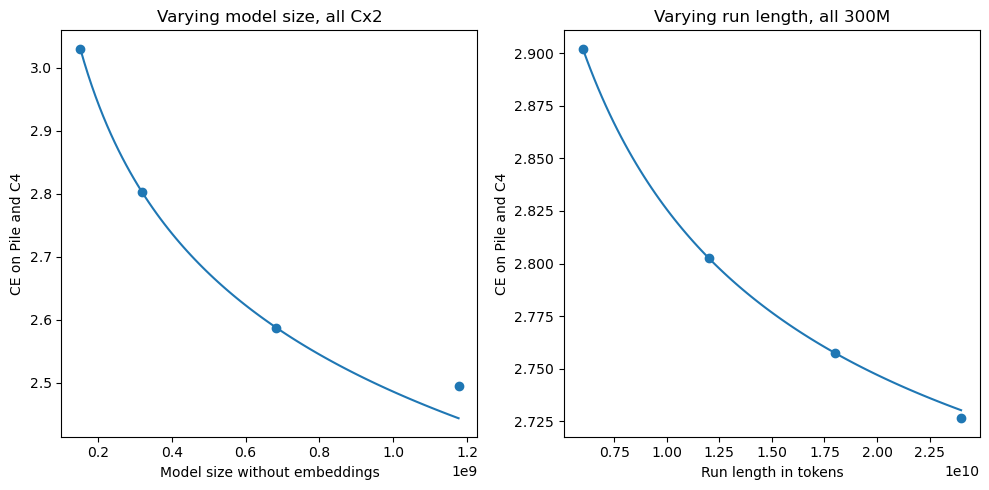

In [6]:
import numpy as np

def power_law(x, a, b, c):
    return a * x ** b + c
power_law_bounds = ([0, -np.inf, 0], [np.inf, 0, np.inf])

from scipy.optimize import curve_fit

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# model size
x = []
y = []
for run in ["baseline-150M-2xC", "baseline-300M-2xC", "baseline-750M-2xC", "baseline-1B-2xC"]:
    _, size, _ = run_name_re.match(run).groups()
    _, size = ladder.size_for_model(size)
    x.append(size)
    y.append((pile_ce[run] + c4_ce[run])/2)

train_x = np.array(x[:-1])
train_y = np.array(y[:-1])
popt, pcov = curve_fit(power_law, train_x, train_y, p0=(100, -0.2, 1.5), bounds=power_law_bounds, max_nfev=10000)
print(popt)
ax1.scatter(x, y)
ax1.set_title("Varying model size, all Cx2")
ax1.set_xlabel("Model size without embeddings")
ax1.set_ylabel("CE on Pile and C4")
x = np.linspace(min(x), max(x), 100)
ax1.plot(x, power_law(x, *popt))

# run length
x = []
y = []
for run in ["baseline-300M-1xC", "baseline-300M-2xC", "baseline-300M-3xC", "baseline-300M-4xC"]:
    _, _, length = parse_run_name(run)
    x.append(length)
    y.append((pile_ce[run] + c4_ce[run])/2)

train_x = np.array(x[:-1])
train_y = np.array(y[:-1])
popt, pcov = curve_fit(power_law, train_x, train_y, p0=(200, -0.5, 2), bounds=power_law_bounds, max_nfev=10000)
print(popt)
ax2.scatter(x, y)
ax2.set_title("Varying run length, all 300M")
ax2.set_xlabel("Run length in tokens")
ax2.set_ylabel("CE on Pile and C4")
x = np.linspace(min(x), max(x), 100)
ax2.plot(x, power_law(x, *popt))

plt.tight_layout()
plt.show()